## Main notebook for testing approaches

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils.cv import preprocess, scale_and_reduce
from utils.data_preparation import concat_with_mi
from plotnine import *

In [9]:
target = pd.read_csv("./input/submission/target.csv", index_col="loan_id")

In [10]:
df_raw = pd.read_pickle("./input/submission/df_wide_raw_vals.df")
df_diff = pd.read_pickle("./input/submission/df_wide_diff.df")
df_diff_sign = pd.read_pickle("./input/submission/df_wide_diff_sign.df")

In [11]:
for df_ in [df_raw, df_diff, df_diff_sign]:
    lids = df_.columns[df_.columns.str.contains("loan_id")]
    df_.drop(columns=lids, inplace=True)

Join to remove the removed loans in X from y

In [12]:
def create_prediction_layout(df, target, y_label: str = "default_at_9"):
    Xy = df.join(target.groupby(level=0).head(1))
    Xy.loc[:, "default_at_9"] = Xy.loc[:, "default_at_9"].astype(int)
    y = Xy[y_label]
    X = Xy.drop(y_label, axis=1)
    return X, y

In [13]:
X_raw, y = create_prediction_layout(df_raw, target)
X_diff, _ =  create_prediction_layout(df_diff, target)
X_diff_sign, _ =  create_prediction_layout(df_diff_sign, target)

Convert to proper dtypes

In [14]:
X_raw = X_raw.convert_dtypes()
X_diff = X_diff.convert_dtypes()
X_diff_sign = X_diff_sign.convert_dtypes()

## Dimensionality reduction check

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [16]:
def plot_explained_variance(X, file_name = None):
    """Plot explained variance as f. of components."""
    X_scaled = StandardScaler().fit_transform(X_raw)
    pca = PCA().fit(X_scaled)   
    X_plt = pd.DataFrame(dict(
        components = range(1, len(X_raw.columns) + 1),
        cvar = np.cumsum(pca.explained_variance_ratio_)
    ))
    plt = (
        ggplot(X_plt, aes(x = "components", y = "cvar")) 
        + geom_line()
        + xlab("Number of components")
        + ylab("Proportion of explained variance")
        + geom_hline(yintercept=[0.95, 0.9, 0.8], linetype='dashed')
    )
    if file_name: ggsave(plot=plt, filename='./figures/' + file_name)
    return plt

In [17]:
plt_pca = plot_explained_variance(X_raw, "pca_raw.pdf")
plt_pca_diff = plot_explained_variance(X_diff, "pca_diff.pdf")
plt_pca_diff_sign = plot_explained_variance(X_diff_sign, "pca_diff_sign.pdf")

/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./figures/pca_raw.pdf
/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./figures/pca_diff.pdf
/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./figures/pca_diff_sign.pdf


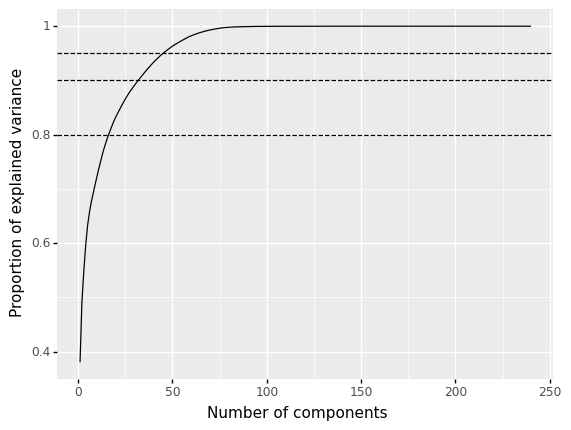

<ggplot: (8781553089549)>

In [18]:
plt_pca

## Model testing

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import Isomap

In [20]:
def report_performance(y_pred, y_true, file_name):
    precision = precision_score(
        y_pred=y_pred,
        y_true=y_true,
        average='macro'
    )
    recall = recall_score(
        y_pred=y_pred,
        y_true=y_true,
        average='macro'
    )
    f1 = f1_score(
        y_pred=y_pred,
        y_true=y_true,
        average='macro'
    )
    print(classification_report(
        y_pred = y_pred,
        y_true = y_true
    ))
    ax = sns.heatmap(
        confusion_matrix(
            y_pred = y_pred,
            y_true = y_true
        ), 
        annot=True, 
        fmt="d",
        yticklabels=["Non-default", "Default"],
        xticklabels=["Non-default", "Default"]
    )
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig("./figures/" + file_name)
    plt.show()
    
    return precision, recall, f1

### All features

In [21]:
clf = LogisticRegression(max_iter = 1000)

              precision    recall  f1-score   support

           0       0.62      0.59      0.61       189
           1       0.61      0.63      0.62       189

    accuracy                           0.61       378
   macro avg       0.61      0.61      0.61       378
weighted avg       0.61      0.61      0.61       378



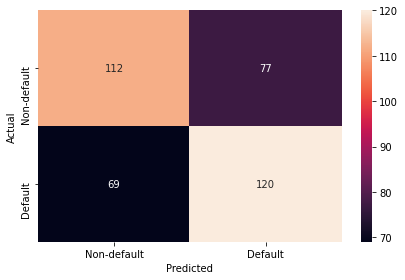

In [22]:
X_tr_af, X_te_af, y_tr_af, y_te_af = train_test_split(X_raw, y)
X_tr_af, X_te_af, y_tr_af = preprocess(reducer = None, X_tr = X_tr_af, X_te= X_te_af, y_tr=y_tr_af)
clf.fit(X_tr_af, y_tr_af)
y_pred_is_af = clf.predict(X_tr_af)
y_pred_oos_af = clf.predict(X_te_af)
# Report performance
precision_tr_af, recall_tr_af, f1_tr_af = report_performance(
    y_pred=y_pred_is_af,
    y_true=y_tr_af,
    file_name="cm_train_baseline.pdf"
)

              precision    recall  f1-score   support

           0       0.94      0.45      0.61       886
           1       0.06      0.56      0.11        59

    accuracy                           0.45       945
   macro avg       0.50      0.50      0.36       945
weighted avg       0.88      0.45      0.57       945



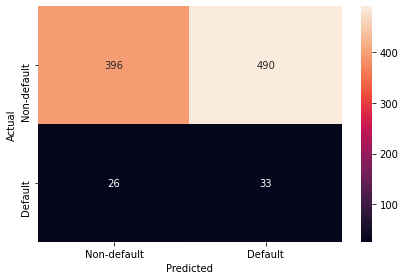

In [23]:
precision_te_af, recall_te_af, f1_te_af = report_performance(
    y_pred=y_pred_oos_af,
    y_true=y_te_af,
    file_name="cm_test_baseline.pdf"
)

### PCA

In [24]:
pca_best_params = np.load("./input/submission/pca_best_params.npy", allow_pickle=True).item(0)
pca_best_data_params = np.load("./input/submission/pca_best_data_params.npy", allow_pickle=True).item(0)

In [25]:
X_pca = pca_best_data_params['X']
add_mi = pca_best_data_params['add_mi']
if add_mi: X_pca = cat_with_mi(X_pca)

In [26]:
X_tr_pca, X_te_pca, y_tr_pca, y_te_pca = train_test_split(X_pca, y, test_size=0.2)

In [27]:
pca = PCA(**pca_best_params)
X_tr_reduced_pca, X_te_reduced_pca, y_tr_pca = preprocess(pca, X_tr_pca, X_te_pca, y_tr_pca, sparse=None)

              precision    recall  f1-score   support

           0       0.63      0.61      0.62       196
           1       0.62      0.64      0.63       196

    accuracy                           0.63       392
   macro avg       0.63      0.63      0.63       392
weighted avg       0.63      0.63      0.63       392



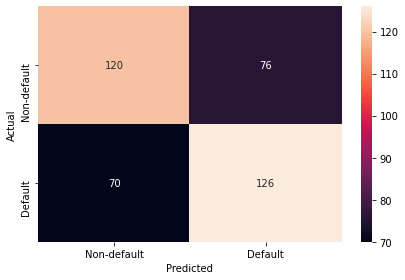

In [28]:
# Predict
clf.fit(X_tr_reduced_pca, y_tr_pca)
y_pred_is_pca = clf.predict(X_tr_reduced_pca)
y_pred_oos_pca = clf.predict(X_te_reduced_pca)
# Report performance
precision_tr_pca, recall_tr_pca, f1_tr_pca = report_performance(
    y_pred=y_pred_is_pca,
    y_true=y_tr_pca,
    file_name="cm_train_pca.pdf"
)

              precision    recall  f1-score   support

           0       0.94      0.51      0.66       704
           1       0.08      0.54      0.13        52

    accuracy                           0.51       756
   macro avg       0.51      0.52      0.40       756
weighted avg       0.88      0.51      0.62       756



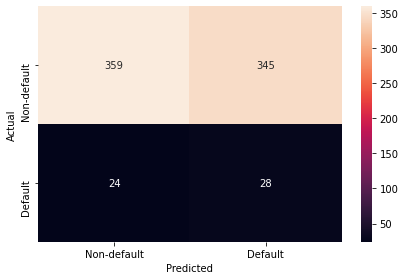

In [29]:
precision_te_pca, recall_te_pca, f1_te_pca = report_performance(
    y_pred=y_pred_oos_pca,
    y_true=y_te_pca,
    file_name="cm_test_pca.pdf"
)

### Isomap

In [30]:
isomap_best_params = np.load("./input/submission/isomap_best_params.npy", allow_pickle=True).item(0)
isomap_best_data_params = np.load("./input/submission/isomap_best_data_params.npy", allow_pickle=True).item(0)

In [31]:
X_isomap = isomap_best_data_params['X']
add_mi = isomap_best_data_params['add_mi']
if add_mi: X_isomap = cat_with_mi(X_isomap)

In [32]:
X_tr_isomap, X_te_isomap, y_tr_isomap, y_te_isomap = train_test_split(X_isomap, y, test_size=0.2, stratify=y)

In [33]:
isomap = Isomap(**isomap_best_params)
X_tr_reduced_isomap, X_te_reduced_isomap, y_tr_isomap = preprocess(isomap, X_tr_isomap, X_te_isomap, y_tr_isomap, sparse=None)

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       198
           1       0.63      0.57      0.60       198

    accuracy                           0.62       396
   macro avg       0.62      0.62      0.62       396
weighted avg       0.62      0.62      0.62       396



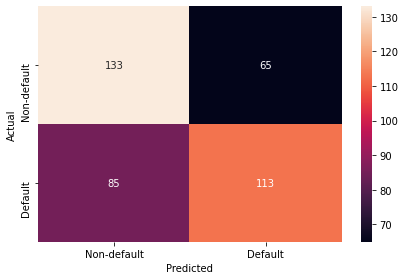

In [34]:
# Predict
clf.fit(X_tr_reduced_isomap, y_tr_isomap)
y_pred_is_isomap = clf.predict(X_tr_reduced_isomap)
y_pred_oos_isomap = clf.predict(X_te_reduced_isomap)
# Report performance
precision_tr_isomap, recall_tr_isomap, f1_tr_isomap = report_performance(
    y_pred=y_pred_is_isomap,
    y_true=y_tr_isomap,
    file_name="cm_train_isomap.pdf"
)

              precision    recall  f1-score   support

           0       0.93      0.50      0.65       706
           1       0.06      0.44      0.10        50

    accuracy                           0.50       756
   macro avg       0.49      0.47      0.38       756
weighted avg       0.87      0.50      0.62       756



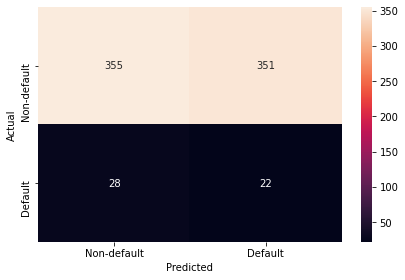

In [35]:
precision_te_isomap, recall_te_isomap, f1_te_isomap = report_performance(
    y_pred=y_pred_oos_isomap,
    y_true=y_te_isomap,
    file_name="cm_test_isomap.pdf"
)

### Autoencoder

In [36]:
def plot_train_val_loss(ae, file_name = None):
    train_val_loss = ae.history[:, ('train_loss', 'valid_loss')]
    loss_df = (pd.DataFrame(train_val_loss)
             .reset_index()
             .rename(columns = {
                 0: 'Train', 
                 1: 'Validation',
                 'index': 'Epoch'
             })
          )
    loss_df_melted = pd.melt(loss_df, value_vars = ["Train", "Validation"], id_vars="Epoch")
    loss_plot = (
        ggplot(loss_df_melted, aes(x = 'Epoch', y = 'value', color = 'variable')) + 
        geom_line() + 
        theme(legend_title=element_blank()) +
        ylab("Reconstruction loss")
    )
    if file_name: ggsave(loss_plot, filename = './figures/' + file_name)
    return loss_plot

In [37]:
from utils.ae import AE, AutoEncoder

In [38]:
ae_best_params = np.load("./input/submission/ae_best_params_512.npy", allow_pickle=True).item(0)
ae_best_data_params = np.load("./input/submission/ae_best_data_params_512.npy", allow_pickle=True).item(0)

In [39]:
X_ae = ae_best_data_params['X']
add_mi = ae_best_data_params['add_mi']
if add_mi: X_ae = concat_with_mi(X_ae)

In [40]:
X_tr_ae, X_te_ae, y_tr_ae, y_te_ae = train_test_split(X_ae, y, test_size=0.2)

In [41]:
_, D = X_tr_ae.shape
sparse = ae_best_params.pop("sparse")

In [42]:
import torch.nn as nn

In [43]:
ae_best_params

{'module__layers': [200, 100, 50],
 'lr': 0.8,
 'module__act_fn': ReLU(),
 'batch_size': 512,
 'max_epochs': 100}

In [44]:
ae = AE(
    AutoEncoder,
    module__D = D,
    verbose=0,
    **ae_best_params,
)

In [45]:
X_tr_reduced_ae, X_te_reduced_ae, y_tr_ae = preprocess(ae, X_tr_ae, X_te_ae, y_tr_ae, sparse=sparse)

In [46]:
loss_plot = plot_train_val_loss(ae, file_name = "train_val_sparse.pdf")

/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./figures/train_val_sparse.pdf


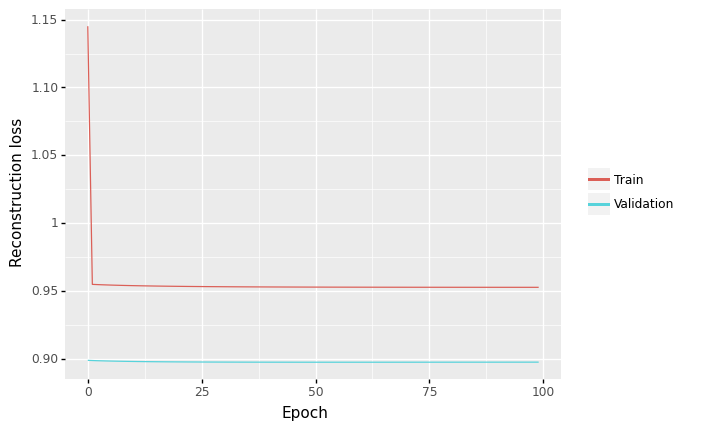

<ggplot: (8781540793389)>

In [47]:
loss_plot

/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0       0.50      1.00      0.67       195
           1       0.00      0.00      0.00       195

    accuracy                           0.50       390
   macro avg       0.25      0.50      0.33       390
weighted avg       0.25      0.50      0.33       390



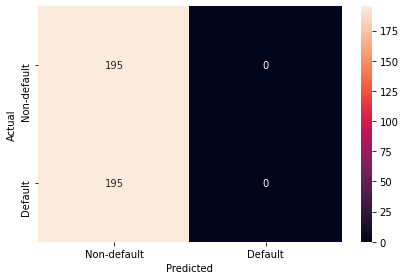

In [48]:
# Predict
clf.fit(X_tr_reduced_ae, y_tr_ae)
y_pred_is_ae = clf.predict(X_tr_reduced_ae)
y_pred_oos_ae = clf.predict(X_te_reduced_ae)
# Report performance
precision_tr_ae, recall_tr_ae, f1_tr_ae = report_performance(
    y_pred=y_pred_is_ae,
    y_true=y_tr_ae,
    file_name="cm_train_ae_sparse.pdf"
)

/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0       0.93      1.00      0.96       703
           1       0.00      0.00      0.00        53

    accuracy                           0.93       756
   macro avg       0.46      0.50      0.48       756
weighted avg       0.86      0.93      0.90       756



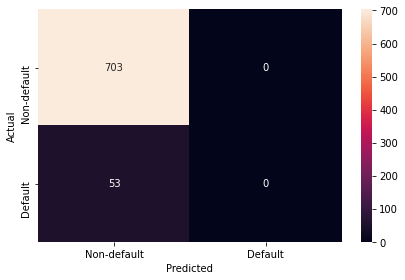

In [49]:
precision_te_ae, recall_te_ae, f1_te_ae = report_performance(
    y_pred=y_pred_oos_ae,
    y_true=y_te_ae,
    file_name="cm_test_ae_sparse.pdf"
)

As the performance metrics shows, the sparse option brings on trouble. Therefore, I use the best option without the sparse solution for a second fit.

In [50]:
ae_best_params_ = np.load("./input/submission/ae_best_params_512_notsparse.npy", allow_pickle=True).item(0)
ae_best_data_params_ = np.load("./input/submission/ae_best_data_params_512_notsparse.npy", allow_pickle=True).item(0)

In [51]:
X_ae = ae_best_data_params_['X']
add_mi = ae_best_data_params_['add_mi']
if add_mi: X_ae = concat_with_mi(X_ae)

In [52]:
X_tr_ae, X_te_ae, y_tr_ae, y_te_ae = train_test_split(X_ae, y, test_size=0.2)

In [53]:
_, D = X_tr_ae.shape
sparse = ae_best_params_.pop('sparse')

In [54]:
ae_best_params_

{'module__layers': [100, 50],
 'lr': 0.8,
 'module__act_fn': LeakyReLU(negative_slope=0.01),
 'batch_size': 512,
 'max_epochs': 100}

In [55]:
ae = AE(
    AutoEncoder,
    module__D = D,
    verbose=0,
    **ae_best_params_,
)

In [56]:
X_tr_reduced_ae, X_te_reduced_ae, y_tr_ae = preprocess(ae, X_tr_ae, X_te_ae, y_tr_ae, sparse=sparse)

In [57]:
loss_plot = plot_train_val_loss(ae, file_name = "train_val_loss.pdf")

/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./figures/train_val_loss.pdf


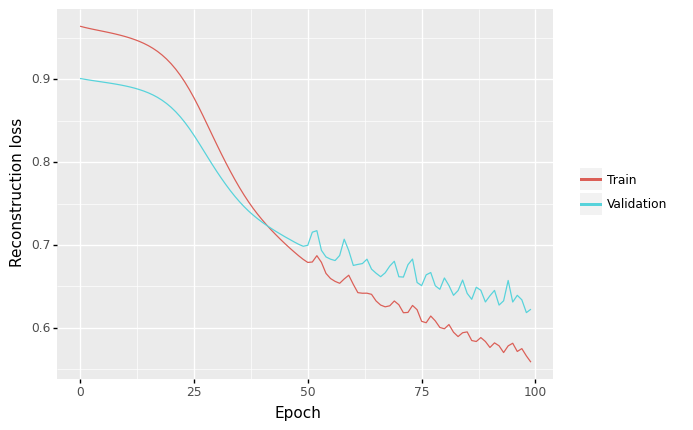

<ggplot: (8781540463069)>

In [58]:
loss_plot

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       203
           1       0.63      0.66      0.64       203

    accuracy                           0.64       406
   macro avg       0.64      0.64      0.64       406
weighted avg       0.64      0.64      0.64       406



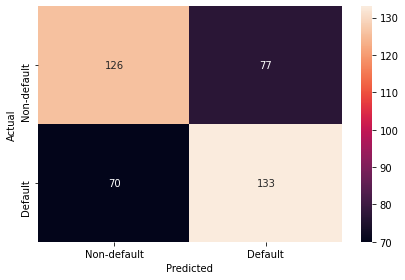

In [59]:
# Predict
clf.fit(X_tr_reduced_ae, y_tr_ae)
y_pred_is_ae = clf.predict(X_tr_reduced_ae)
y_pred_oos_ae = clf.predict(X_te_reduced_ae)
# Report performance
precision_tr_ae, recall_tr_ae, f1_tr_ae = report_performance(
    y_pred=y_pred_is_ae,
    y_true=y_tr_ae,
    file_name="cm_train_ae.pdf"
)

              precision    recall  f1-score   support

           0       0.94      0.50      0.65       711
           1       0.06      0.47      0.10        45

    accuracy                           0.49       756
   macro avg       0.50      0.48      0.37       756
weighted avg       0.88      0.49      0.62       756



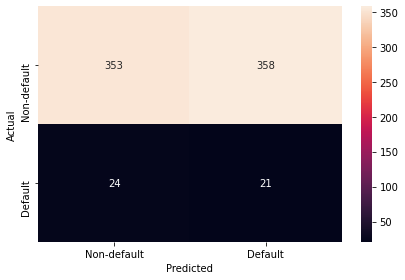

In [60]:
precision_te_ae, recall_te_ae, f1_te_ae = report_performance(
    y_pred=y_pred_oos_ae,
    y_true=y_te_ae,
    file_name="cm_test_ae.pdf"
)

We see that in fact we can keep training...

In [61]:
ae_best_params_ = {
    'module__layers': [100, 50],
    'lr': 0.8,
    'module__act_fn': nn.LeakyReLU(negative_slope=0.01),
    'batch_size': 512,
    'max_epochs': 1000}

In [62]:
ae = AE(
    AutoEncoder,
    module__D = D,
    verbose=0,
    **ae_best_params_,
)

In [63]:
X_tr_ae, X_te_ae, y_tr_ae, y_te_ae = train_test_split(X_ae, y, test_size=0.2)

In [64]:
X_tr_reduced_ae, X_te_reduced_ae, y_tr_ae = preprocess(ae, X_tr_ae, X_te_ae, y_tr_ae, sparse=sparse)

In [65]:
loss_plot = plot_train_val_loss(ae, file_name = "train_val_loss_epochs.pdf")

/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/ludvigwgerdin/courses/Machine Learning for Finance/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./figures/train_val_loss_epochs.pdf


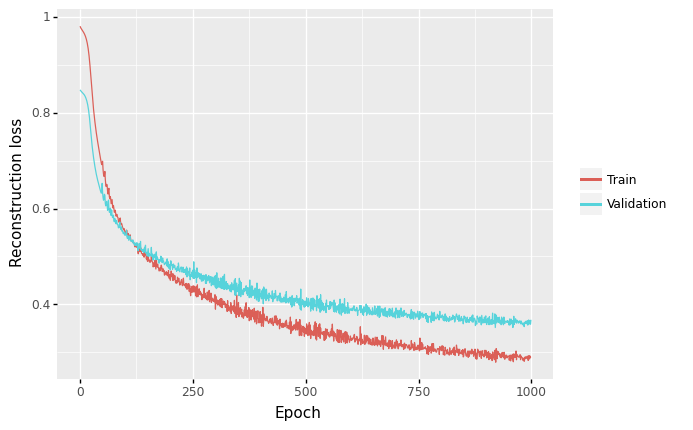

<ggplot: (8781540625301)>

In [66]:
loss_plot

After approximately 875 epochs, we see that the validation loss has in fact stagnated. Therefore, we use this number of epochs for the final fitting.

Fit to the full train-validation partition

In [69]:
ae_best_params_final = {
    'module__layers': [100, 50],
    'lr': 0.8,
    'module__act_fn': nn.LeakyReLU(negative_slope=0.01),
    'batch_size': 512,
    'max_epochs': 875
}

In [70]:
ae = AE(
    AutoEncoder,
    module__D = D,
    verbose=0,
    train_split = None,
    **ae_best_params_final,
)

In [71]:
X_tr_ae, X_te_ae, y_tr_ae, y_te_ae = train_test_split(X_ae, y, test_size=0.2)

In [72]:
X_tr_reduced_ae, X_te_reduced_ae, y_tr_ae = preprocess(ae, X_tr_ae, X_te_ae, y_tr_ae, sparse=sparse)

              precision    recall  f1-score   support

           0       0.63      0.61      0.62       191
           1       0.62      0.64      0.63       191

    accuracy                           0.63       382
   macro avg       0.63      0.63      0.63       382
weighted avg       0.63      0.63      0.63       382



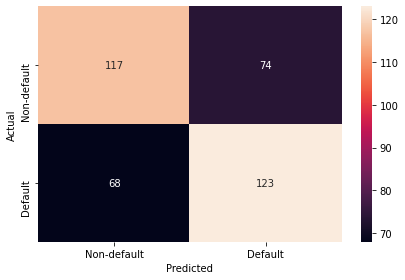

In [75]:
# Predict
clf.fit(X_tr_reduced_ae, y_tr_ae)
y_pred_is_ae = clf.predict(X_tr_reduced_ae)
y_pred_oos_ae = clf.predict(X_te_reduced_ae)
# Report performance
precision_tr_ae, recall_tr_ae, f1_tr_ae = report_performance(
    y_pred=y_pred_is_ae,
    y_true=y_tr_ae,
    file_name="cm_train_ae_final.pdf"
)

              precision    recall  f1-score   support

           0       0.92      0.49      0.64       699
           1       0.07      0.46      0.12        57

    accuracy                           0.49       756
   macro avg       0.49      0.47      0.38       756
weighted avg       0.85      0.49      0.60       756



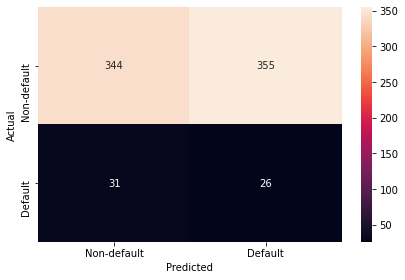

In [76]:
precision_te_ae, recall_te_ae, f1_te_ae = report_performance(
    y_pred=y_pred_oos_ae,
    y_true=y_te_ae,
    file_name="cm_test_ae_final.pdf"
)